## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
Ans:dropout rate =0.2時精度及loss最佳(相較於0.3及0.4), 無論是3層5層或7層的網路
但是愈多層,精度及loss會逐漸變差

2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果
Ans:dropout rate =0.2 3層的情況下,與SGD的結果差不多


In [10]:
import os
import keras
import itertools
from keras.layers import Dropout
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.20,0.30,0.40]
LayerList= [[512, 256, 128],[512,512,256,256, 128],[512,512,512,256,256,256, 128]]


In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for layers in LayerList:
    for Dropout_rate in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Dropout_rate = %.6f, layer_count=%d" % (Dropout_rate,len(layers)))
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=layers,drp_ratio=Dropout_rate)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-dropout-%1.4f layter=%d" % (Dropout_rate,len(layers))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0721 20:03:42.309006  8484 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Experiment with Dropout_rate = 0.200000, layer_count=3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)  

W0721 20:03:42.472008  8484 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 20:03:42.605012  8484 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 306us/step - loss: 2.1838 - acc: 0.1947 - val_loss: 1.9719 - val_acc: 0.3054
Epoch 2/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.9709 - acc: 0.2857 - val_loss: 1.8511 - val_acc: 0.3427
Epoch 3/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.8860 - acc: 0.3214 - val_loss: 1.7796 - val_acc: 0.3678
Epoch 4/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.8289 - acc: 0.3439 - val_loss: 1.7263 - val_acc: 0.3850
Epoch 5/50
50000/50000 [==============================] - 14s 283us/step - loss: 1.7840 - acc: 0.3598 - val_loss: 1.6823 - val_acc: 0.4049
Epoch 6/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.7466 - acc: 0.3737 - val_loss: 1.6520 - val_acc: 0.4187
Epoch 7/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.7183 - acc: 0.3858 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 293us/step - loss: 2.2130 - acc: 0.1732 - val_loss: 2.0190 - val_acc: 0.2912
Epoch 2/50
50000/50000 [==============================] - 14s 283us/step - loss: 2.0244 - acc: 0.2543 - val_loss: 1.9008 - val_acc: 0.3339
Epoch 3/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.9394 - acc: 0.2959 - val_loss: 1.8301 - val_acc: 0.3620
Epoch 4/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.8893 - acc: 0.3165 - val_loss: 1.7773 - val_acc: 0.3744
Epoch 5/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.8481 - acc: 0.3330 - val_loss: 1.7410 - val_acc: 0.3875
Epoch 6/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.8131 - acc: 0.3482 - val_loss: 1.7005 - val_acc: 0.4040
Epoch 7/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.7817 - acc: 0.3602 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 300us/step - loss: 2.2538 - acc: 0.1582 - val_loss: 2.0735 - val_acc: 0.2744
Epoch 2/50
50000/50000 [==============================] - 15s 290us/step - loss: 2.0871 - acc: 0.2214 - val_loss: 1.9592 - val_acc: 0.3099
Epoch 3/50
50000/50000 [==============================] - 15s 290us/step - loss: 2.0060 - acc: 0.2560 - val_loss: 1.8854 - val_acc: 0.3272
Epoch 4/50
50000/50000 [==============================] - 15s 290us/step - loss: 1.9551 - acc: 0.2819 - val_loss: 1.8454 - val_acc: 0.3438
Epoch 5/50
50000/50000 [==============================] - 14s 290us/step - loss: 1.9171 - acc: 0.2986 - val_loss: 1.8102 - val_acc: 0.3618
Epoch 6/50
50000/50000 [==============================] - 15s 290us/step - loss: 1.8871 - acc: 0.3125 - val_loss: 1.7697 - val_acc: 0.3741
Epoch 7/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.8608 - acc: 0.3252 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 359us/step - loss: 2.2625 - acc: 0.1468 - val_loss: 2.1131 - val_acc: 0.2219
Epoch 2/50
50000/50000 [==============================] - 17s 349us/step - loss: 2.0850 - acc: 0.2196 - val_loss: 1.9547 - val_acc: 0.2914
Epoch 3/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.9763 - acc: 0.2682 - val_loss: 1.8693 - val_acc: 0.3254
Epoch 4/50
50000/50000 [==============================] - 17s 346us/step - loss: 1.9127 - acc: 0.2990 - val_loss: 1.8118 - val_acc: 0.3465
Epoch 5/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.8652 - acc: 0.3178 - val_loss: 1.7572 - val_acc: 0.3674
Epoch 6/50
50000/50000 [==============================] - 17s 346us/step - loss: 1.8205 - acc: 0.3352 - val_loss: 1.7136 - val_acc: 0.3812
Epoch 7/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.7837 - acc: 0.3518 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 357us/step - loss: 2.2994 - acc: 0.1241 - val_loss: 2.2113 - val_acc: 0.1920
Epoch 2/50
50000/50000 [==============================] - 17s 348us/step - loss: 2.1839 - acc: 0.1737 - val_loss: 2.0660 - val_acc: 0.2550
Epoch 3/50
50000/50000 [==============================] - 17s 347us/step - loss: 2.0847 - acc: 0.2129 - val_loss: 1.9651 - val_acc: 0.2963
Epoch 4/50
50000/50000 [==============================] - 17s 346us/step - loss: 2.0140 - acc: 0.2475 - val_loss: 1.8996 - val_acc: 0.3127
Epoch 5/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.9631 - acc: 0.2697 - val_loss: 1.8505 - val_acc: 0.3305
Epoch 6/50
50000/50000 [==============================] - 17s 347us/step - loss: 1.9218 - acc: 0.2834 - val_loss: 1.8098 - val_acc: 0.3458
Epoch 7/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.8926 - acc: 0.3003 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 354us/step - loss: 2.3182 - acc: 0.1112 - val_loss: 2.2759 - val_acc: 0.1693
Epoch 2/50
50000/50000 [==============================] - 17s 348us/step - loss: 2.2665 - acc: 0.1367 - val_loss: 2.1973 - val_acc: 0.1658
Epoch 3/50
50000/50000 [==============================] - 17s 345us/step - loss: 2.1963 - acc: 0.1620 - val_loss: 2.1154 - val_acc: 0.1824
Epoch 4/50
50000/50000 [==============================] - 17s 345us/step - loss: 2.1352 - acc: 0.1808 - val_loss: 2.0626 - val_acc: 0.2171
Epoch 5/50
50000/50000 [==============================] - 17s 347us/step - loss: 2.0986 - acc: 0.1905 - val_loss: 2.0260 - val_acc: 0.2348
Epoch 6/50
50000/50000 [==============================] - 17s 347us/step - loss: 2.0637 - acc: 0.2094 - val_loss: 1.9789 - val_acc: 0.2573
Epoch 7/50
50000/50000 [==============================] - 17s 348us/step - loss: 2.0272 - acc: 0.2229 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 418us/step - loss: 2.2974 - acc: 0.1150 - val_loss: 2.2538 - val_acc: 0.1524
Epoch 2/50
50000/50000 [==============================] - 20s 403us/step - loss: 2.2066 - acc: 0.1597 - val_loss: 2.0919 - val_acc: 0.1947
Epoch 3/50
50000/50000 [==============================] - 20s 403us/step - loss: 2.0998 - acc: 0.1917 - val_loss: 2.0152 - val_acc: 0.2427
Epoch 4/50
50000/50000 [==============================] - 20s 405us/step - loss: 2.0365 - acc: 0.2239 - val_loss: 1.9380 - val_acc: 0.2735
Epoch 5/50
50000/50000 [==============================] - 20s 405us/step - loss: 1.9732 - acc: 0.2555 - val_loss: 1.8711 - val_acc: 0.3008
Epoch 6/50
50000/50000 [==============================] - 20s 404us/step - loss: 1.9232 - acc: 0.2816 - val_loss: 1.8248 - val_acc: 0.3261
Epoch 7/50
50000/50000 [==============================] - 20s 404us/step - loss: 1.8858 - acc: 0.2983 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 413us/step - loss: 2.3095 - acc: 0.1054 - val_loss: 2.2897 - val_acc: 0.1574
Epoch 2/50
50000/50000 [==============================] - 20s 402us/step - loss: 2.2798 - acc: 0.1232 - val_loss: 2.2382 - val_acc: 0.1610
Epoch 3/50
50000/50000 [==============================] - 21s 430us/step - loss: 2.2156 - acc: 0.1580 - val_loss: 2.1461 - val_acc: 0.1791
Epoch 4/50
50000/50000 [==============================] - 20s 405us/step - loss: 2.1580 - acc: 0.1744 - val_loss: 2.0951 - val_acc: 0.1905
Epoch 5/50
50000/50000 [==============================] - 21s 423us/step - loss: 2.1203 - acc: 0.1801 - val_loss: 2.0566 - val_acc: 0.2177
Epoch 6/50
50000/50000 [==============================] - 21s 424us/step - loss: 2.0899 - acc: 0.1918 - val_loss: 2.0240 - val_acc: 0.2363
Epoch 7/50
50000/50000 [==============================] - 22s 433us/step - loss: 2.0520 - acc: 0.2118 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 20s 410us/step - loss: 2.3259 - acc: 0.1029 - val_loss: 2.3013 - val_acc: 0.1061
Epoch 2/50
50000/50000 [==============================] - 20s 398us/step - loss: 2.3031 - acc: 0.1037 - val_loss: 2.3012 - val_acc: 0.1015
Epoch 3/50
50000/50000 [==============================] - 20s 395us/step - loss: 2.3006 - acc: 0.1089 - val_loss: 2.3012 - val_acc: 0.1004
Epoch 4/50
50000/50000 [==============================] - 20s 401us/step - loss: 2.2981 - acc: 0.1119 - val_loss: 2.2999 - val_acc: 0.1418
Epoch 5/50
50000/50000 [==============================] - 20s 398us/step - loss: 2.2929 - acc: 0.1237 - val_loss: 2.2960 - val_acc: 0.1490
Epoch 6/50
50000/50000 [==============================] - 20s 400us/step - loss: 2.2811 - acc: 0.1348 - val_loss: 2.2781 - val_acc: 0.1788
Epoch 7/50
50000/50000 [==============================] - 20s 401us/step - loss: 2.2438 - acc: 0.1637 - val_loss: 2.

In [22]:
len(results)

9

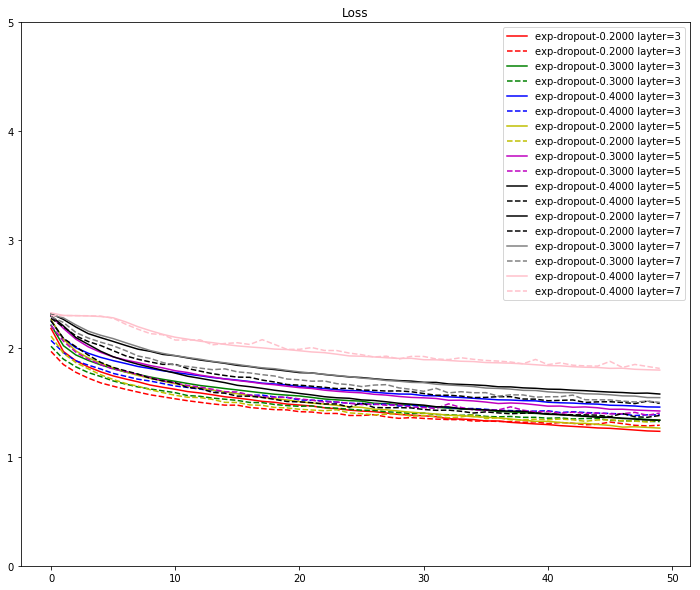

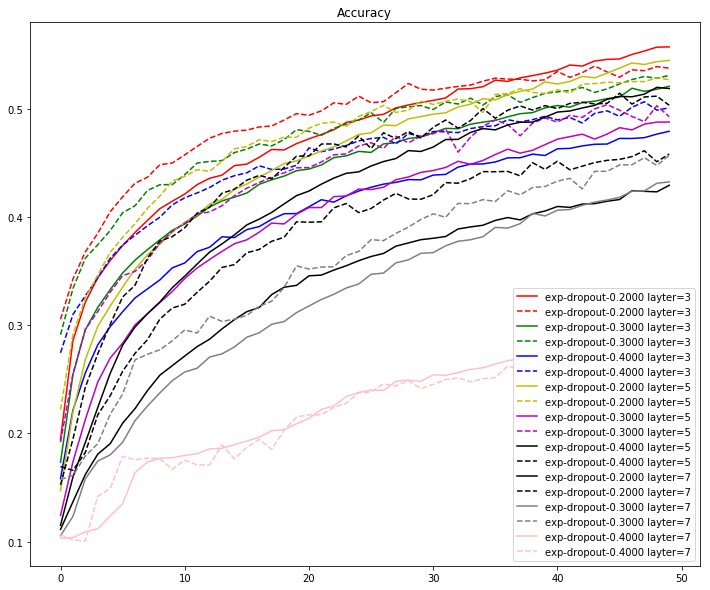

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray','pink']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<9:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()


In [26]:
Dropout_rate = 0.2

keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with Dropout_rate = %.6f, layer_count=%d" % (Dropout_rate,len(layers)))
model = build_mlp(input_shape=x_train.shape[1:],drp_ratio=Dropout_rate)
model.summary()
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss1 = model.history.history["loss"]
valid_loss1 = model.history.history["val_loss"]
train_acc1 = model.history.history["acc"]
valid_acc1 = model.history.history["val_acc"]

Experiment with Dropout_rate = 0.200000, layer_count=7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)  

Epoch 49/50
50000/50000 [==============================] - 18s 365us/step - loss: 1.3921 - acc: 0.4994 - val_loss: 1.3959 - val_acc: 0.5034
Epoch 50/50
50000/50000 [==============================] - 18s 364us/step - loss: 1.3816 - acc: 0.5026 - val_loss: 1.3851 - val_acc: 0.5107


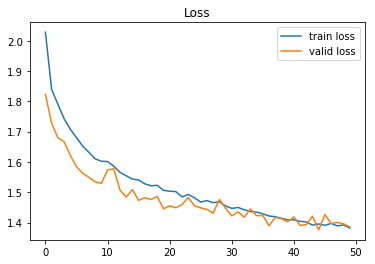

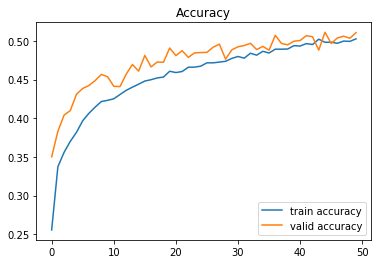

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss1)), train_loss1, label="train loss")
plt.plot(range(len(valid_loss1)), valid_loss1, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc1)), train_acc1, label="train accuracy")
plt.plot(range(len(valid_acc1)), valid_acc1, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()